# 63_inclass_cluster_example

Preprocess data, a bit of feature engineering, PCA, clustering and then plotting

## Imports

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
import pandas as pd
import numpy as np
import datetime

# Display all cell outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

from IPython import get_ipython
ipython = get_ipython()

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

# Set max rows and columns displayed in jupyter
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", 100)

#the following gives access to utils folder
#where utils package stores shared code
import os
import sys
PROJECT_ROOT = os.path.abspath(os.path.join(
                  os.getcwd(),
                  os.pardir)
)

#only add it once
if (PROJECT_ROOT not in sys.path):
    sys.path.append(PROJECT_ROOT)

# autoreload extension
if 'autoreload' not in ipython.extension_manager.loaded:
    %load_ext autoreload

%autoreload 2

## Constants and Functions
Migrate these to a separate package when done so they can be used with scripts

In [2]:
F_ORIG="Mall_Customers.csv"
F_NEW="Mall_CustomersNew.csv"
RSEED=7

## Modify existing dataset
Existing dataset is a bit to perfect, this section makes it less so to give you a chance to work on pre processing skills

In [3]:

def generate_birthday(age):
    '''
    takes age in years and generates a birthday age many years ago
    age: how old in years
    returns: datetime
    '''
    year = datetime.datetime.now().year -age #get year born
    month=np.random.randint(1,12,1)[0]  #random month
    day=np.random.randint(1,29,1)[0]  #random day
    return pd.to_datetime(datetime.datetime(year, month, day))


def generate_sales(df):
    '''
    df: dataframe, Spending score column is expanded into 3 columns according to foloowing formula
    spending_score=(args[0]*sales_alcohol + args[1]*sales_food + args[2]*sale_items)/3
    returns: modified df
    '''
    #get 3 random numbers that add to 1
    numbs=np.random.random(size=3)
    numbs=numbs/sum(numbs)
    spending_score=df['Spending Score (1-100)']
    alcohol = numbs[0]*spending_score
    food = numbs[1]*spending_score
    sale = numbs[2]*spending_score
    return alcohol, food, sale

df = pd.read_csv(F_ORIG)

# un tidy the data
df['Birthday']=df.Age.map(generate_birthday)
df[['spending_alcohol','spending_food','spending_sale']] =df.apply(generate_sales, axis=1,result_type ='expand')
df=df.drop(columns=['Spending Score (1-100)','Age'])  #drop
df['Active']=True   #a column with no variance
df.loc[197,'Annual Income (k$)']=np.nan  # create a NaN to catch
df=df.append([df.iloc[199,:]] * 5, ignore_index=True)  #add some duplicates

df.to_csv(F_NEW, index=False)
# df

## Preprocess

In [4]:
#load
df= pd.read_csv(F_NEW)
df

,CustomerID,Gender,Annual Income (k$),Birthday,spending_alcohol,spending_food,spending_sale,Active
0,1,Male,15.0,2003-08-06,22.592964,0.151376,16.255659,True
1,2,Male,15.0,2001-11-24,21.377379,19.614856,40.007765,True
2,3,Female,16.0,2002-02-03,0.955797,2.022825,3.021378,True
3,4,Female,16.0,1999-09-06,28.688026,24.215654,24.096320,True
4,5,Female,17.0,1991-06-25,20.519885,7.917019,11.563096,True
...,...,...,...,...,...,...,...,...
200,200,Male,137.0,1992-01-11,31.485994,30.307886,21.206121,True
201,200,Male,137.0,1992-01-11,31.485994,30.307886,21.206121,True
202,200,Male,137.0,1992-01-11,31.485994,30.307886,21.206121,True
203,200,Male,137.0,1992-01-11,31.485994,30.307886,21.206121,True


### Drop duplicates

In [5]:
df.drop_duplicates(inplace=True)
# df

### What are the types of data

In [6]:
#what are types, where are catagoricals
df.dtypes

CustomerID              int64
Gender                 object
Annual Income (k$)    float64
Birthday               object
spending_alcohol      float64
spending_food         float64
spending_sale         float64
Active                   bool
dtype: object

### pairplot to see if anything looks funny
In this case Active has no variance and CustomerID is weirdly correlated with Annual Income.  It appears that they collected all customer data, sorted by income, and then assigned a customer ID to the sorted data

Relative Plot Of Some Selected Features: A Data Subset


<Figure size 432x288 with 0 Axes>

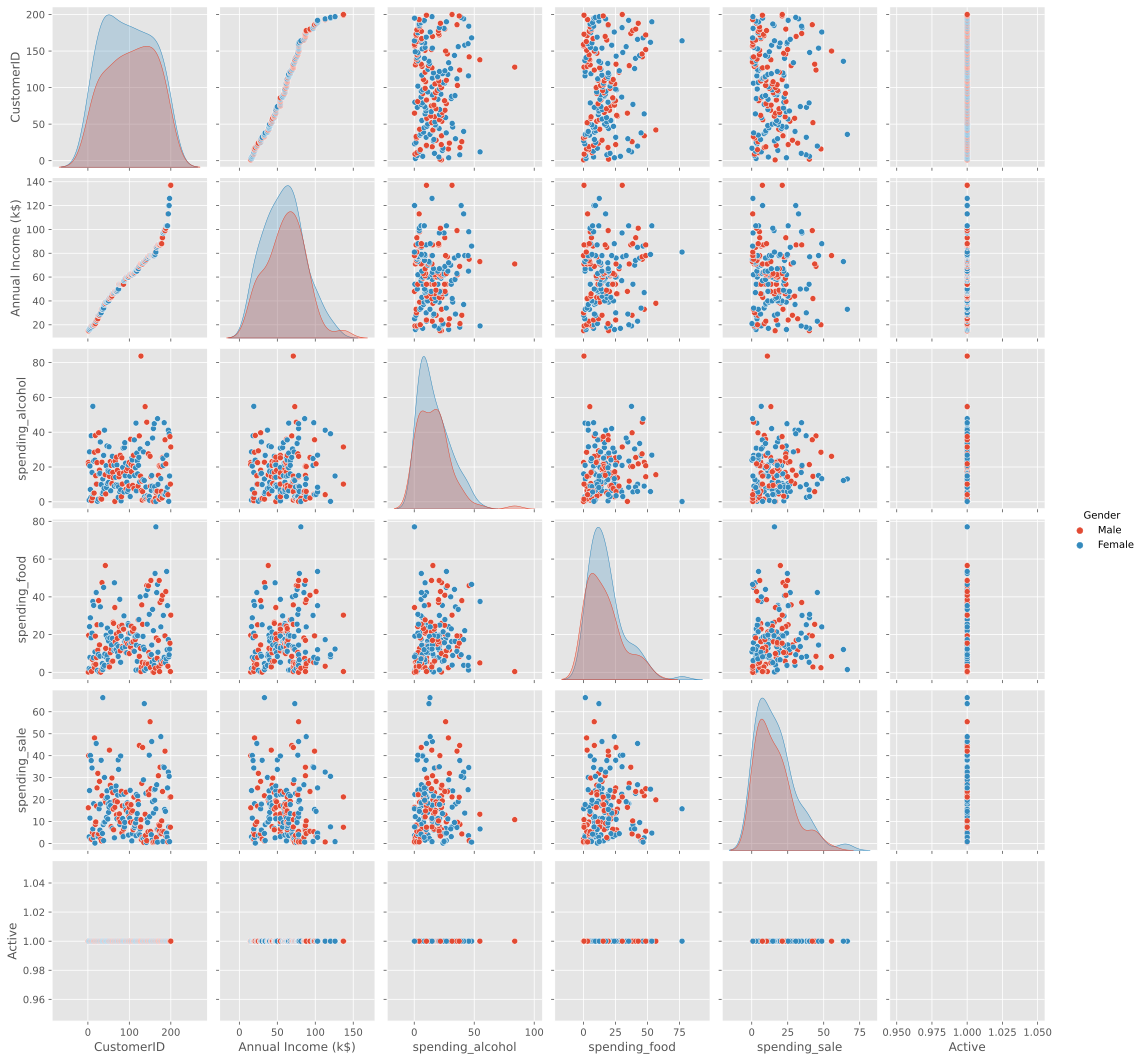

In [7]:
#lets compare each feature to all other features
#this works on a small dataset, will be prohibitivly slow on a larger one
To_Plot = [ col for col in df.columns]
print("Relative Plot Of Some Selected Features: A Data Subset")
plt.figure()
sns.pairplot(data=df[To_Plot], hue="Gender")
plt.show();

### Drop no variance columns

In [8]:
#convert the bool
# df["Active"]=df["Active"].astype(int)
#any variance in this column
df.Active.value_counts()

True    200
Name: Active, dtype: int64

In [9]:
#nope, dump it
df.drop("Active", axis=1, inplace=True)

### Feature engineering- combine all spending columns into 1.  This assummes one value can accurately capture spending patterns. This also reduces number of features

In [10]:
#lets combine the last 3 into 1
def combine_columns(df, newcolname, cols ):
    '''
    df: dataframe
    newcolname: the name of the column to create that has the sum of all columns in cols
    cols: list of columns to add
    return: modded dataframe
    '''
    df[newcolname] = df[cols].sum(axis=1)
    df.drop(cols, axis=1, inplace=True)
    return df

cols=[col for col in df.columns if "spending" in col]
data=combine_columns(df,"spending_total",cols)

### Correlations

In [11]:
#find correlations,
corr_matrix=df.corr()
corr_matrix

,CustomerID,Annual Income (k$),spending_total
CustomerID,1.000000,0.978744,0.013835
Annual Income (k$),0.978744,1.000000,-0.001725
spending_total,0.013835,-0.001725,1.000000


In [12]:
# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find features with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

#to find pairs
to_drop=[(col,row) for col in upper.columns for row in upper[f'{col}'].index.tolist() if not pd.isnull(upper.loc[f'{row}',f'{col}']) and upper.loc[f'{row}',f'{col}']>0.95]

to_drop
# Drop features 
# df.drop(to_drop, axis=1, inplace=True)

[('Annual Income (k$)', 'CustomerID')]

#### Annual Income is highly correlated with CustomerID, drop one.  But be sure to keep the one that has the most information!

In [13]:
df.drop("CustomerID", axis=1, inplace=True)
# df

In [14]:
df.dtypes

Gender                 object
Annual Income (k$)    float64
Birthday               object
spending_total        float64
dtype: object

### Handle all catagoricals
Convert tonumeric

In [15]:
#find cats
#get all categorical columns
cats=[col for col in df.columns if df[f'{col}'].dtype == 'O']

for col in cats:
    print(f'{col} has {df[f"{col}"].nunique()} unique values')

Gender has 2 unique values
Birthday has 197 unique values


In [16]:
#convert Gender
d= {v:i for i,v in enumerate(df.Gender.unique().tolist())}
df.Gender=df.Gender.map(d)

In [17]:
#convert birthday to age in years
import datetime
def getyear(v):
    return datetime.datetime.now().year - pd.to_datetime(v).year
df['Birthday']=df.Birthday.map(getyear) 

### Handle nulls
Just drop if there are not too many and you can't figure out how to estimate<br>
(You could estimate by taking the value before and after since the data was sorted by income before CustomerIDs were assigned)

In [18]:
#any null
df.isnull().values.any()

#see em
df[df.isnull().any(axis=1)]

#drop em
df.dropna(axis=0, inplace=True);

In [19]:
#save for later plotting
df_unscaled=df.copy()

### Standardize

In [23]:
import utils as ut
from sklearn.preprocessing import StandardScaler
df=(df.pipe(ut.scale,df.columns.tolist(),StandardScaler()))
df

ValueError: could not convert string to float: '?'

### PCA

In [21]:
## PCA

from sklearn.decomposition import PCA

pca = PCA(n_components=.95, whiten=True)
features_pca=pd.DataFrame(pca.fit_transform(df))
print(f'Orig #features={df.shape[1]}, number features containing 95% of variance={features_pca.shape[1]}')

features_pca
pca.explained_variance_ratio_

Orig #features=4, number features containing 95% of variance=4


,0,1,2,3
0,-0.371057,-0.582497,-2.106778,1.635290
1,-1.244413,-0.422019,-2.326460,0.112835
2,-0.013142,-1.854861,-0.288134,2.665130
3,-1.505555,-1.580117,-0.662959,0.114909
4,-0.324775,-1.779986,-0.356730,0.854352
...,...,...,...,...
194,0.971125,1.080885,2.404957,0.582527
195,-0.969922,1.457856,1.939267,-0.777780
196,0.617830,1.331159,2.463345,0.300793
197,0.744209,2.891760,1.068261,1.432227


array([0.33733016, 0.25809097, 0.23606481, 0.16851406])

In [22]:
#run the existing pipeline? see 41_load_util_package...
#now we can get to it
import utils as ut
# dir(ut)

In [23]:
from sklearn.preprocessing import StandardScaler
cols_to_one_hot=['Gender']
cols_to_scale=[col for col in df.columns if col != 'Gender']

df_clean=(df.pipe(ut.cat_getdummies, cols_to_one_hot).
            pipe(ut.scale, cols_to_scale, StandardScaler()))

# df_clean

# Cluster

## KMeans

In [24]:
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans

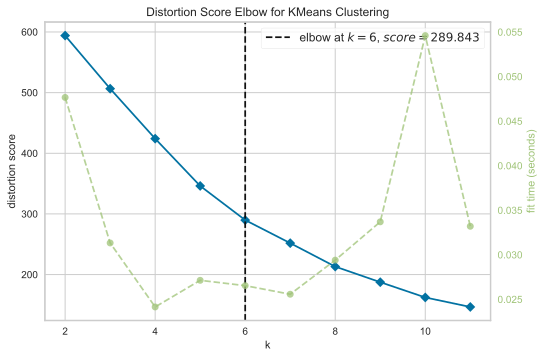

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [25]:
# Instantiate the clustering model and visualizer
model = KMeans(random_state=RSEED)
MIN_CLUSTERS=2
MAX_CLUSTERS=12
visualizer = KElbowVisualizer(model, k=(MIN_CLUSTERS,MAX_CLUSTERS))

a=visualizer.fit(features_pca)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

In [26]:
from sklearn.cluster import KMeans

# initialize with k-means++, this puts the initial cluster choices as far away from each other
# as possible which increases the chances for convergence
kmeans = KMeans(n_clusters=5, init='k-means++', random_state=RSEED).fit(features_pca.iloc[:,[0,1,2,3]].to_numpy())

In [28]:
df_unscaled['cluster']=kmeans.labels_
df_unscaled

,Gender,Annual Income (k$),Birthday,spending_total,cluster
0,0,15.0,19,39.0,1
1,0,15.0,21,81.0,1
2,1,16.0,20,6.0,2
3,1,16.0,23,77.0,2
4,1,17.0,31,40.0,2
...,...,...,...,...,...
194,1,120.0,47,16.0,4
195,1,120.0,35,79.0,0
196,1,126.0,45,28.0,4
198,0,137.0,32,18.0,4


## DBSCAN

### TODO calculate eps estimate min_samples, then calculate clusters based using DBSCAN

# Plot

### What do the plots mean? If anything.
You can only look at 3 features at a time if you are showing clusters as colors.<br>
So look at a plot of all females, and then all males.  ARe any clusters exclusively female or male? <br>
ARe there any other clusters that clearly indicate similarities?<br>
Are there any that appear to be pointlessly mixed with other clusters?<br>
If so should you try reducing the number of clusters calculated?

In [35]:
#lets plot 1 for male and 1 for female
dfm=df_unscaled[df_unscaled['Gender']==0]
dff=df_unscaled[df_unscaled['Gender']==1]

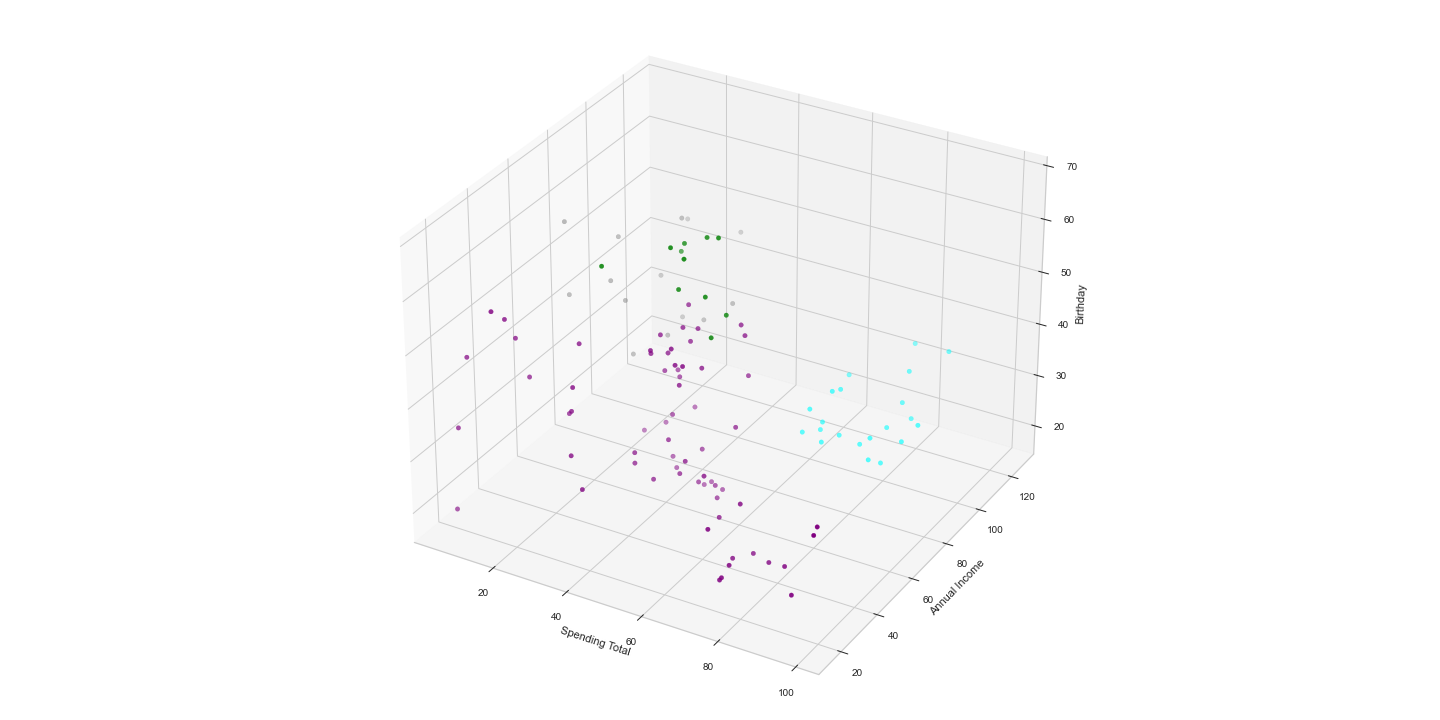

In [37]:
dfplt=dff
colors1 = {-1:"brown",
            0:"cyan",
           1:"orange", 
           2:"purple",
           3:"green",
          4:"gray",
          5:"red",
          6:"blue"}
# %%capture
# importing required libraries
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection, Line3DCollection
%matplotlib ipympl

# creating figure
fig = plt.figure(figsize=(20,10));

ax = Axes3D(fig,auto_add_to_figure=False);
ignore=ax.set_facecolor("white");
ignore=ax.grid(color="black");

ignore=fig.add_axes(ax,frameon=False)  #<Axes3D:>
colors=dfplt['cluster'].map(colors1)
# creating the plot
ignore=ax.scatter(dfplt.iloc[:,3], dfplt.iloc[:,1], dfplt.iloc[:,2], c=colors)  #<mpl_toolkits.mplot3d.art3d.Path3DCollection at 0x7f98ea314070>

# setting title and labels
ignore=ax.set_title("3D plot")
ignore=ax.set_xlabel('Spending Total')
ignore=ax.set_ylabel('Annual Income')
ignore=ax.set_zlabel('Birthday')
plt.show();
plt.figure().clear();
plt.close()

## Compare cluster membership as determined by kmeans and DBSCAN